In [1]:
import os
import re
import sys
from collections import Counter
from pathlib import Path

import networkx as nx

sys.path.append('/torchok')
os.chdir('../')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from skimage import io
from PIL.Image import open as iopen
from sklearn.model_selection import train_test_split

sns.set()

In [2]:
def plot_images(imgs, names=None, axs=None, show=True, nrows=None, ncols=None, figsize=(16, 8), filename='out'):
    if not isinstance(imgs, list):
        imgs = [imgs]

    from math import ceil
    if nrows is None and ncols is None:
        nrows = 1
        ncols = len(imgs)
    elif nrows is None:
        nrows = ceil(len(imgs) / ncols)
    elif ncols is None:
        ncols = ceil(len(imgs) / nrows)

    if axs is None:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axs.imshow(imgs[0])
        axs.set_axis_off()
        if names and len(names) > 0:
            axs.set_title(names[0], fontsize=15)
    elif nrows == 1 or ncols == 1:
        for j, ax in enumerate(axs):
            ax.imshow(imgs[j])
            ax.set_axis_off()
            if names and j < len(names):
                ax.set_title(names[j], fontsize=15)
    else:
        for j, ax in enumerate(axs):
            for k, sub_ax in enumerate(ax):
                image_id = j * ncols + k
                sub_ax.set_axis_off()
                if image_id < len(imgs):
                    sub_ax.imshow(imgs[image_id])
                    if names and image_id < len(names):
                        sub_ax.set_title(names[image_id], fontsize=15)
    if show:
        plt.show()


def flatten(x):
    return [i for j in x for i in j]

In [3]:
def save_csv(df, path_or_buf, cols_with_path_list=tuple()):
    df = df.copy()
    for col in cols_with_path_list:
        df[col] = df[col].apply(lambda x: ' '.join(map(str, x)))
    df.to_csv(path_or_buf, index=False)


def load_csv(filepath_or_buffer, cols_with_path_list=tuple()):
    pattern = re.compile("[^,'\s\[\]]+")
    df = pd.read_csv(filepath_or_buffer)
    for col in cols_with_path_list:
        df[col] = df[col].fillna('').apply(pattern.findall)
    return df


def urls_to_paths(urls):
    return [image_dir.joinpath(*Path(i).parts[2:]) for i in urls]

In [7]:
image_dir = Path('images')
full = load_csv('matches_photo_wb_lm.csv', ['wb_images', 'lm_images']).reset_index().rename(
    columns={'index': 'product_id'})
test_idx = load_csv('test_orig.csv').rename(columns={'Unnamed: 0': 'product_id'})['product_id']

full['wb_img_paths'] = full.wb_images.apply(urls_to_paths)
full['lm_img_paths'] = full.lm_images.apply(urls_to_paths)

idx2cat = dict(enumerate(set(full.lm_categories)))
cat2idx = {v: k for k, v in idx2cat.items()}
full['category_label'] = full.lm_categories.map(cat2idx)
save_csv(full, 'full.csv', ['wb_images', 'lm_images', 'wb_img_paths', 'lm_img_paths'])

In [13]:
full

,product_id,wb_sku,lm_sku,wb_categories,wb_images,lm_categories,lm_images,wb_img_paths,lm_img_paths,category_label
0,0,82733,GO001CUBHJ95,NaN,[https://img1.wbstatic.net/large/new/80000/827...,HEADWEAR,[http://pi3.lmcdn.ru/product/G/O/GO001CUBHJ95_...,"[images/large/new/80000/82733-1.jpg, images/la...","[images/product/G/O/GO001CUBHJ95_1.jpg, images...",73
1,1,82733,GO001CUKS963,NaN,[https://img1.wbstatic.net/large/new/80000/827...,HEADWEAR,[http://pi3.lmcdn.ru/product/G/O/GO001CUKS963_...,"[images/large/new/80000/82733-1.jpg, images/la...",[images/product/G/O/GO001CUKS963_1131118_1_v2....,73
2,2,93264,AD093AMASU51,NaN,[https://img2.wbstatic.net/large/new/90000/932...,FLIP FLOPS,[http://pi3.lmcdn.ru/product/A/D/AD093AMASU51_...,"[images/large/new/90000/93264-1.jpg, images/la...",[images/product/A/D/AD093AMASU51_1347688_1_v4....,25
3,3,93292,AD093AMBL190,NaN,[https://img2.wbstatic.net/large/new/90000/932...,FLIP FLOPS,[http://pi3.lmcdn.ru/product/A/D/AD093AMBL190_...,"[images/large/new/90000/93292-1.jpg, images/la...",[images/product/A/D/AD093AMBL190_275624_1_v2.j...,25
4,4,93713,AD094AMATN26,NaN,[https://img1.wbstatic.net/large/new/90000/937...,FOOTBALL BOOTS,[http://pi3.lmcdn.ru/product/A/D/AD094AMATN26_...,"[images/large/new/90000/93713-1.jpg, images/la...",[images/product/A/D/AD094AMATN26_1350154_1_v2....,1
...,...,...,...,...,...,...,...,...,...,...
270630,270630,12143219,CO066LWCTRU3,"['Красота', 'Волосы', 'Для роста волос']",[https://img1.wbstatic.net/large/new/12140000/...,HAIR CARE,[http://pi3.lmcdn.ru/product/C/O/CO066LWCTRU3_...,[images/large/new/12140000/12143219-1.jpg],[images/product/C/O/CO066LWCTRU3_7265541_1_v1....,50
270631,270631,12143220,CO066LWCTRU4,"['Красота', 'Волосы', 'Для роста волос']",[https://images.wbstatic.net/large/new/1214000...,HAIR CARE,[http://pi3.lmcdn.ru/product/C/O/CO066LWCTRU4_...,[images/large/new/12140000/12143220-1.jpg],[images/product/C/O/CO066LWCTRU4_7265542_1_v1....,50
270632,270632,12143221,CO066LWCTRU5,"['Красота', 'Волосы', 'Шампуни и кондиционеры']",[https://images.wbstatic.net/large/new/1214000...,HAIR CARE,[http://pi3.lmcdn.ru/product/C/O/CO066LWCTRU5_...,[images/large/new/12140000/12143221-1.jpg],[images/product/C/O/CO066LWCTRU5_7265543_1_v1....,50
270633,270633,12143222,CO066LWCTRU6,"['Красота', 'Волосы', 'Для роста волос']",[https://images.wbstatic.net/large/new/1214000...,HAIR CARE,[http://pi3.lmcdn.ru/product/C/O/CO066LWCTRU6_...,[images/large/new/12140000/12143222-1.jpg],[images/product/C/O/CO066LWCTRU6_7265544_1_v1....,50


### See also code in CheckFilesCorrectness.ipynb to remove broken images

In [4]:
image_dir = Path('images')
full = load_csv('full.csv', ['wb_images', 'lm_images', 'wb_img_paths', 'lm_img_paths'])
full['wb_img_paths'] = full.wb_images.apply(urls_to_paths)
full['lm_img_paths'] = full.lm_images.apply(urls_to_paths)

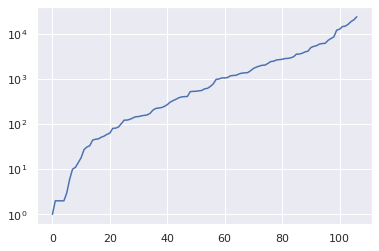

In [5]:
categories = full.groupby('lm_categories').agg(len)['wb_categories'].sort_values()
plt.plot(categories.values)
plt.yscale('log')

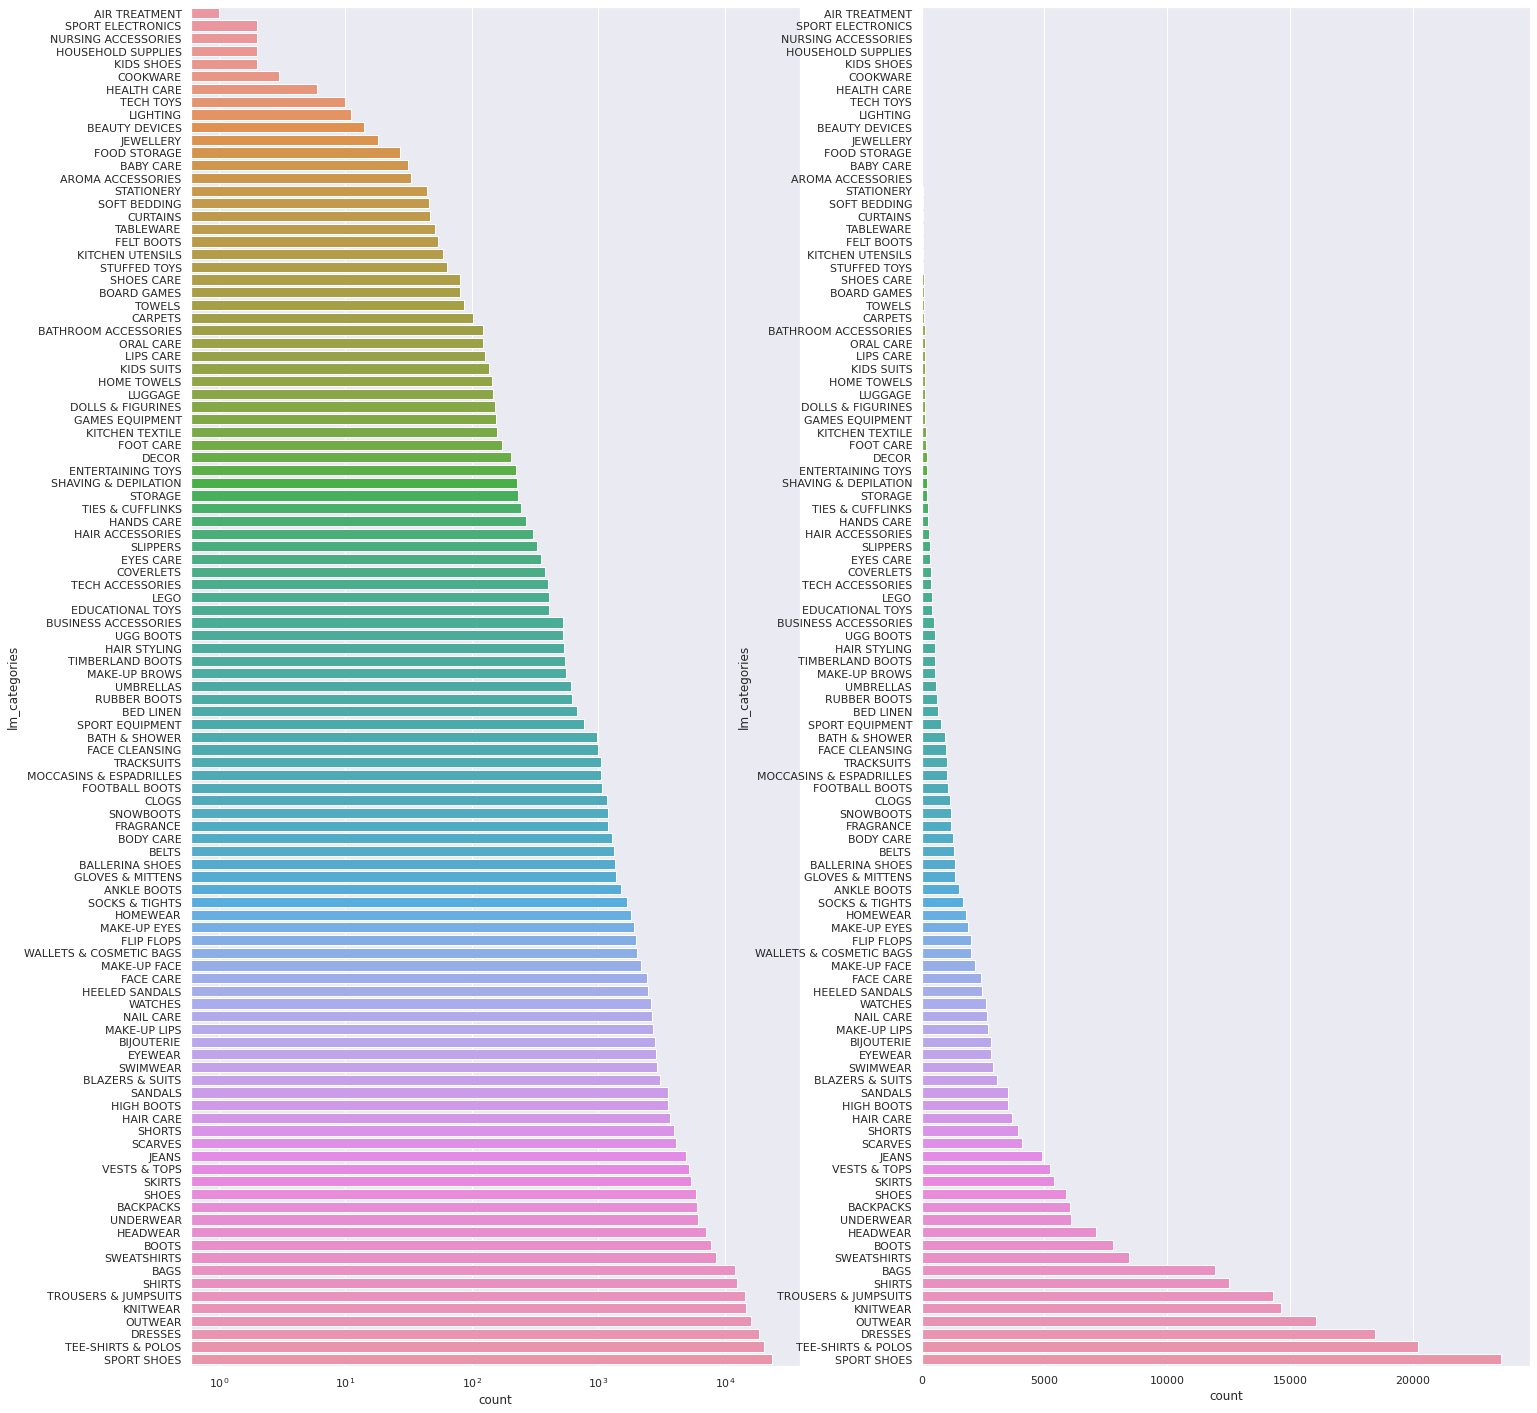

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(24, 25))
axs[0].set_xscale('log')
sns.countplot(y='lm_categories', data=full, orient='h', order=categories.index, ax=axs[0])
sns.countplot(y='lm_categories', data=full, orient='h', order=categories.index, ax=axs[1])
plt.show()

In [7]:
categories[:10]

lm_categories
AIR TREATMENT           1
SPORT ELECTRONICS       2
NURSING ACCESSORIES     2
HOUSEHOLD SUPPLIES      2
KIDS SHOES              2
COOKWARE                3
HEALTH CARE             6
TECH TOYS              10
LIGHTING               11
BEAUTY DEVICES         14
Name: wb_categories, dtype: int64

In [8]:
i = -1

0


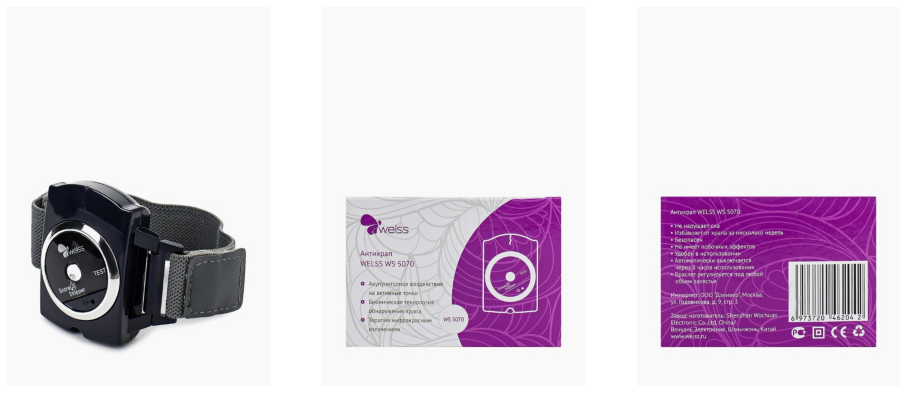

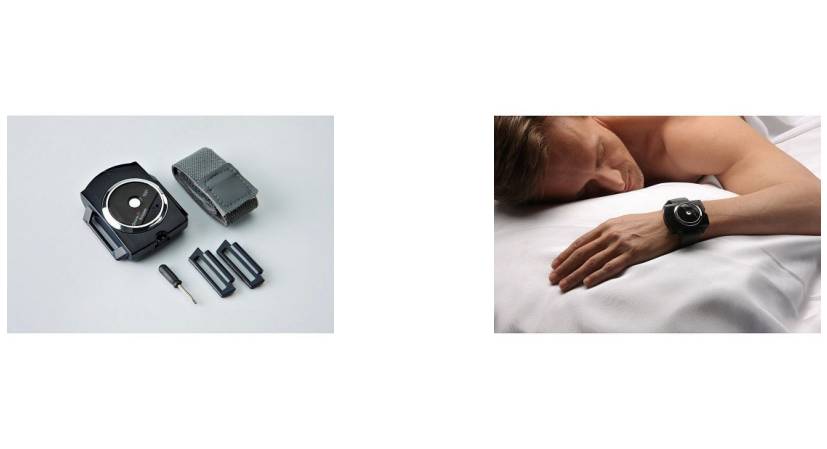

In [9]:
i += 1
print(i)
plot_images([np.array(iopen(j)) for j in full[full.lm_categories == 'HEALTH CARE'].iloc[i]['lm_img_paths']])
plot_images([np.array(iopen(j)) for j in full[full.lm_categories == 'HEALTH CARE'].iloc[i]['wb_img_paths']])

In [10]:
full.wb_categories = full.wb_categories.fillna('[]').apply(eval)
full.wb_categories

0                                                []
1                                                []
2                                                []
3                                                []
4                                                []
                            ...                    
270630           [Красота, Волосы, Для роста волос]
270631           [Красота, Волосы, Для роста волос]
270632    [Красота, Волосы, Шампуни и кондиционеры]
270633           [Красота, Волосы, Для роста волос]
270634                     [Женщинам, Одежда, Юбки]
Name: wb_categories, Length: 270635, dtype: object

In [11]:
Counter(full.wb_categories.apply(len))

Counter({0: 212387, 3: 38733, 4: 14887, 2: 4547, 5: 81})

In [12]:
i = -1

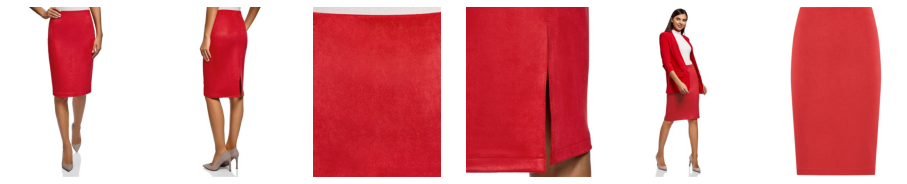

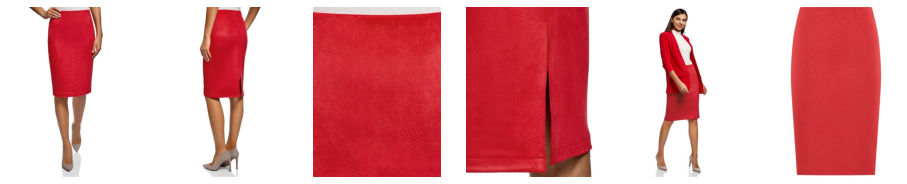

In [13]:
images = [np.array(iopen(j)) for j in full.iloc[i]['wb_img_paths']]
img = images[0]
plot_images(images)

images = [io.imread(j) for j in full.iloc[i]['wb_images']]
plot_images(images)

In [14]:
i = -1

0


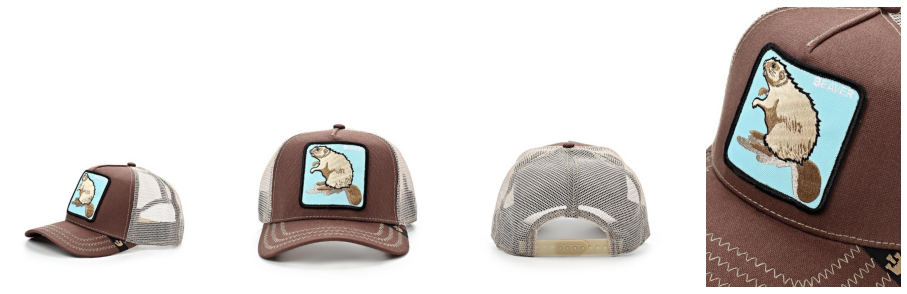

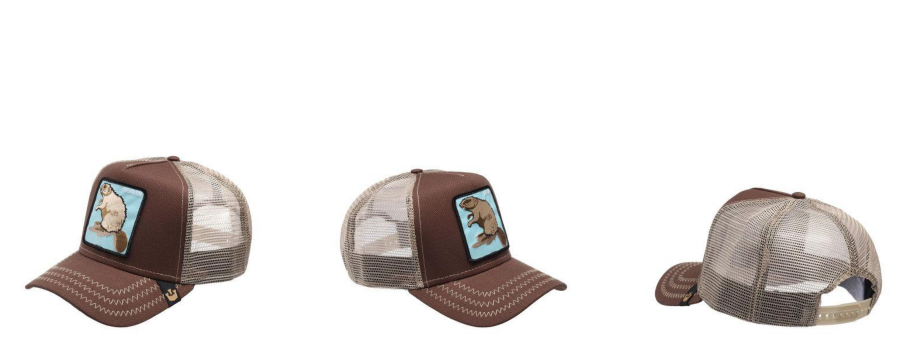

In [15]:
i += 1
print(i)
plot_images([np.array(iopen(j)) for j in full.iloc[i]['lm_img_paths']])
plot_images([np.array(iopen(j)) for j in full.iloc[i]['wb_img_paths']])

In [135]:
lm_duplicated = full.lm_sku.value_counts() > 1
wb_duplicated = full.wb_sku.value_counts() > 1
is_duplicated = full.wb_sku.isin(wb_duplicated[wb_duplicated].index) | full.lm_sku.isin(
    lm_duplicated[lm_duplicated].index)

to_train = test_idx[is_duplicated[test_idx].values]
to_test = test_idx[~is_duplicated[test_idx].values]

test_ids = full.product_id.isin(to_test)
test = full[test_ids]

train_val = full[~(test_ids | is_duplicated)]
train_dedicated = full[is_duplicated]

In [123]:
print(len(test) + len(train_val), len(full))
len(test) + len(train_val) == len(full)

270635 270635


True

In [19]:
i = -1

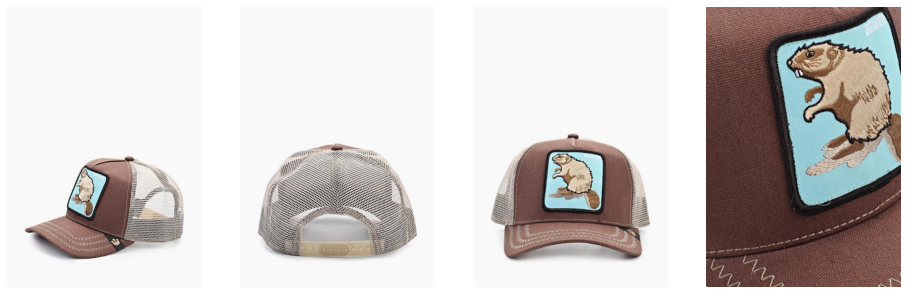

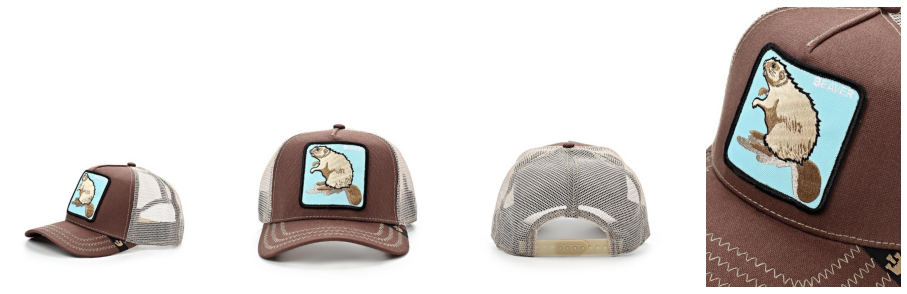

In [20]:
i += 2
plot_images([np.array(iopen(j)) for j in train_dedicated.iloc[i]['lm_img_paths']])
plot_images([np.array(iopen(j)) for j in train_dedicated.iloc[i - 1]['lm_img_paths']])

2


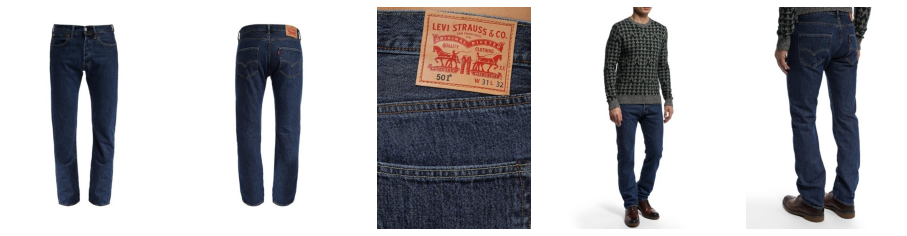

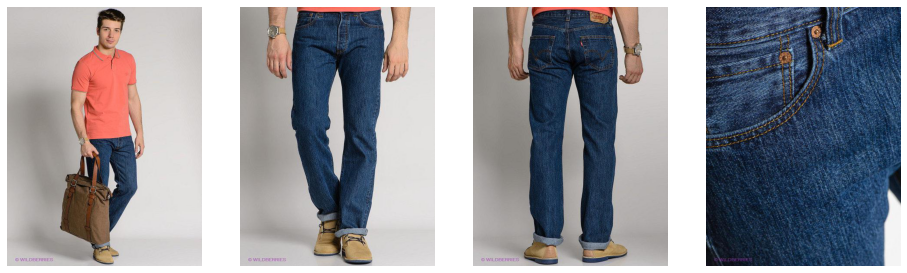

In [21]:
i += 1
print(i)
plot_images([np.array(iopen(j)) for j in train_dedicated.iloc[i]['lm_img_paths']])
plot_images([np.array(iopen(j)) for j in train_dedicated.iloc[i]['wb_img_paths']])

In [136]:
# train_val, test = train_test_split(train_val_test, test_size=50000, stratify=train_val_test.category_label, random_state=42)
# test = pd.concat([test_dedicated, test])

train_categories = train_val.groupby('lm_categories').agg(len)['wb_categories'].sort_values()
small_category = train_val.lm_categories.isin(train_categories[train_categories == 1].index)
valid_dedicated = train_val[small_category]
train_val = train_val[~small_category]

train, valid = train_test_split(train_val, test_size=10000, stratify=train_val.category_label, random_state=42)
valid = pd.concat([valid_dedicated, valid])
train = pd.concat([train_dedicated, train])

In [137]:
len(test) + len(valid) + len(train) == len(full)

True

In [138]:
train

,product_id,wb_sku,lm_sku,wb_categories,wb_images,lm_categories,lm_images,wb_img_paths,lm_img_paths,category_label,category_label_extended
0,0,82733,GO001CUBHJ95,[],[https://img1.wbstatic.net/large/new/80000/827...,HEADWEAR,[http://pi3.lmcdn.ru/product/G/O/GO001CUBHJ95_...,"[images/large/new/80000/82733-1.jpg, images/la...","[images/product/G/O/GO001CUBHJ95_1.jpg, images...",73,270708
1,1,82733,GO001CUKS963,[],[https://img1.wbstatic.net/large/new/80000/827...,HEADWEAR,[http://pi3.lmcdn.ru/product/G/O/GO001CUKS963_...,"[images/large/new/80000/82733-1.jpg, images/la...",[images/product/G/O/GO001CUKS963_1131118_1_v2....,73,270708
15,15,121575,LE306EMDDW14,[],[https://img1.wbstatic.net/large/new/120000/12...,JEANS,[http://pi3.lmcdn.ru/product/L/E/LE306EMDDW14_...,"[images/large/new/120000/121575-1.jpg, images/...","[images/product/L/E/LE306EMDDW14_1.jpg, images...",8,270643
16,16,121575,LE306EMFTB85,[],[https://img1.wbstatic.net/large/new/120000/12...,JEANS,[http://pi3.lmcdn.ru/product/L/E/LE306EMFTB85_...,"[images/large/new/120000/121575-1.jpg, images/...",[images/product/L/E/LE306EMFTB85_2577423_1_v2....,8,270643
19,19,121581,LE306EMBTL56,[],[https://img1.wbstatic.net/large/new/120000/12...,JEANS,[http://pi3.lmcdn.ru/product/L/E/LE306EMBTL56_...,"[images/large/new/120000/121581-1.jpg, images/...","[images/product/L/E/LE306EMBTL56_1.jpg, images...",8,270643
...,...,...,...,...,...,...,...,...,...,...,...
22438,22438,1862294,TI007DMDIP96,[],[https://img2.wbstatic.net/large/new/1860000/1...,WATCHES,[http://pi3.lmcdn.ru/product/T/I/TI007DMDIP96_...,"[images/large/new/1860000/1862294-1.jpg, image...","[images/product/T/I/TI007DMDIP96_1.jpg, images...",62,270697
86971,86971,2950299,JO005LUKKQ49,[],[https://img1.wbstatic.net/large/new/2950000/2...,HAIR CARE,[http://pi3.lmcdn.ru/product/J/O/JO005LUKKQ49_...,[images/large/new/2950000/2950299-1.jpg],[images/product/J/O/JO005LUKKQ49_3575241_1_v2....,50,270685
154696,154696,6113552,AF003AMCASV0,[],[https://img2.wbstatic.net/large/new/6110000/6...,BOOTS,[http://pi3.lmcdn.ru/product/A/F/AF003AMCASV0_...,"[images/large/new/6110000/6113552-1.jpg, image...",[images/product/A/F/AF003AMCASV0_7119764_1_v1....,59,270694
45729,45729,2141938,ZA004EWFQM98,[],[https://img2.wbstatic.net/large/new/2140000/2...,SKIRTS,[http://pi3.lmcdn.ru/product/Z/A/ZA004EWFQM98_...,"[images/large/new/2140000/2141938-1.jpg, image...","[images/product/Z/A/ZA004EWFQM98_1_v2.jpg, ima...",19,270654


In [139]:
full['category_label_extended'] = full['category_label'] + len(set(full.product_id))
unique_labels = full[['category_label_extended', 'product_id']].values
leaves = set(full.product_id)
branches = set(full.category_label)
labels = leaves.union(branches)
num_leaves = len(leaves)
print(num_leaves)

leaf_graph = nx.DiGraph()
leaf_graph.add_nodes_from(labels)
for row in unique_labels:
    for i in range(len(row) - 1):
        for j in range(i + 1, len(row)):
            leaf_graph.add_edge(row[i], row[j])
torch.save(leaf_graph, 'graph.pth')

270635


In [140]:
save_csv(full, 'full.csv', ['wb_images', 'lm_images', 'wb_img_paths', 'lm_img_paths'])
save_csv(train, 'train.csv', ['wb_images', 'lm_images', 'wb_img_paths', 'lm_img_paths'])
save_csv(valid, 'valid.csv', ['wb_images', 'lm_images', 'wb_img_paths', 'lm_img_paths'])
save_csv(test, 'test.csv', ['wb_images', 'lm_images', 'wb_img_paths', 'lm_img_paths'])

In [158]:
save_csv(test[['product_id', 'wb_sku', 'lm_sku', 'wb_categories', 'wb_images', 'lm_categories', 'lm_images']],
         'test2_eora.csv', ['wb_images', 'lm_images'])

In [27]:
full.head()

,product_id,wb_sku,lm_sku,wb_categories,wb_images,lm_categories,lm_images,wb_img_paths,lm_img_paths,category_label
0,0,82733,GO001CUBHJ95,[],[https://img1.wbstatic.net/large/new/80000/827...,HEADWEAR,[http://pi3.lmcdn.ru/product/G/O/GO001CUBHJ95_...,"[images/large/new/80000/82733-1.jpg, images/la...","[images/product/G/O/GO001CUBHJ95_1.jpg, images...",73
1,1,82733,GO001CUKS963,[],[https://img1.wbstatic.net/large/new/80000/827...,HEADWEAR,[http://pi3.lmcdn.ru/product/G/O/GO001CUKS963_...,"[images/large/new/80000/82733-1.jpg, images/la...",[images/product/G/O/GO001CUKS963_1131118_1_v2....,73
2,2,93264,AD093AMASU51,[],[https://img2.wbstatic.net/large/new/90000/932...,FLIP FLOPS,[http://pi3.lmcdn.ru/product/A/D/AD093AMASU51_...,"[images/large/new/90000/93264-1.jpg, images/la...",[images/product/A/D/AD093AMASU51_1347688_1_v4....,25
3,3,93292,AD093AMBL190,[],[https://img2.wbstatic.net/large/new/90000/932...,FLIP FLOPS,[http://pi3.lmcdn.ru/product/A/D/AD093AMBL190_...,"[images/large/new/90000/93292-1.jpg, images/la...",[images/product/A/D/AD093AMBL190_275624_1_v2.j...,25
4,4,93713,AD094AMATN26,[],[https://img1.wbstatic.net/large/new/90000/937...,FOOTBALL BOOTS,[http://pi3.lmcdn.ru/product/A/D/AD094AMATN26_...,"[images/large/new/90000/93713-1.jpg, images/la...",[images/product/A/D/AD094AMATN26_1350154_1_v2....,1


In [28]:
dfs = []
for rec in tqdm(full.iloc, total=len(full)):
    paths = rec.lm_img_paths + rec.wb_img_paths
    df = pd.DataFrame(paths, columns=['image_path'])
    df[['product_id', 'category_label']] = rec[['product_id', 'category_label']]
    dfs.append(df)
dfs = pd.concat(dfs, ignore_index=True)

100%|██████████| 270635/270635 [08:02<00:00, 560.42it/s]


In [44]:
broken = urls_to_paths(['http://pi3.lmcdn.ru/product/I/N/IN002EMEXM04_2_v1.jpg',
                        'https://img1.wbstatic.net/large/new/2020000/2025739-3.jpg',
                        'https://img1.wbstatic.net/large/new/2020000/2025739-4.jpg',
                        'https://img1.wbstatic.net/large/new/2480000/2486063-4.jpg',
                        'https://img2.wbstatic.net/large/new/2750000/2756940-3.jpg',
                        'https://img1.wbstatic.net/large/new/2800000/2800721-1.jpg',
                        'https://img1.wbstatic.net/large/new/2800000/2800721-2.jpg',
                        'https://img1.wbstatic.net/large/new/2800000/2800721-3.jpg',
                        'https://img1.wbstatic.net/large/new/2800000/2800721-4.jpg',
                        'https://img1.wbstatic.net/large/new/2800000/2800721-5.jpg',
                        'https://img2.wbstatic.net/large/new/2810000/2818690-1.jpg',
                        'https://img2.wbstatic.net/large/new/2810000/2818690-2.jpg',
                        'https://img1.wbstatic.net/large/new/3020000/3020275-2.jpg',
                        'https://img1.wbstatic.net/large/new/3020000/3020275-3.jpg',
                        'https://img1.wbstatic.net/large/new/3020000/3020275-5.jpg',
                        'https://img2.wbstatic.net/large/new/3020000/3020298-3.jpg',
                        'https://img2.wbstatic.net/large/new/3020000/3020298-4.jpg',
                        'https://img2.wbstatic.net/large/new/3020000/3020298-7.jpg',
                        'https://img2.wbstatic.net/large/new/3070000/3077736-3.jpg',
                        'https://img1.wbstatic.net/large/new/3100000/3100213-4.jpg',
                        'https://img1.wbstatic.net/large/new/3100000/3100213-4.jpg',
                        'https://img2.wbstatic.net/large/new/3100000/3108510-7.jpg',
                        'https://img1.wbstatic.net/large/new/3110000/3110149-4.jpg',
                        'https://img2.wbstatic.net/large/new/3110000/3111542-5.jpg',
                        'https://img1.wbstatic.net/large/new/3120000/3124321-4.jpg',
                        'https://img2.wbstatic.net/large/new/3150000/3153730-4.jpg',
                        'https://img2.wbstatic.net/large/new/3600000/3606094-7.jpg',
                        'http://pi3.lmcdn.ru/product/E/S/ES021AMCMCQ1_7105336_4_v1.jpg',
                        'https://images.wbstatic.net/large/new/11500000/11503791-1.jpg'])
dfs.image_path = dfs.image_path.apply(Path)
dfs = dfs[~dfs.image_path.isin(broken)]

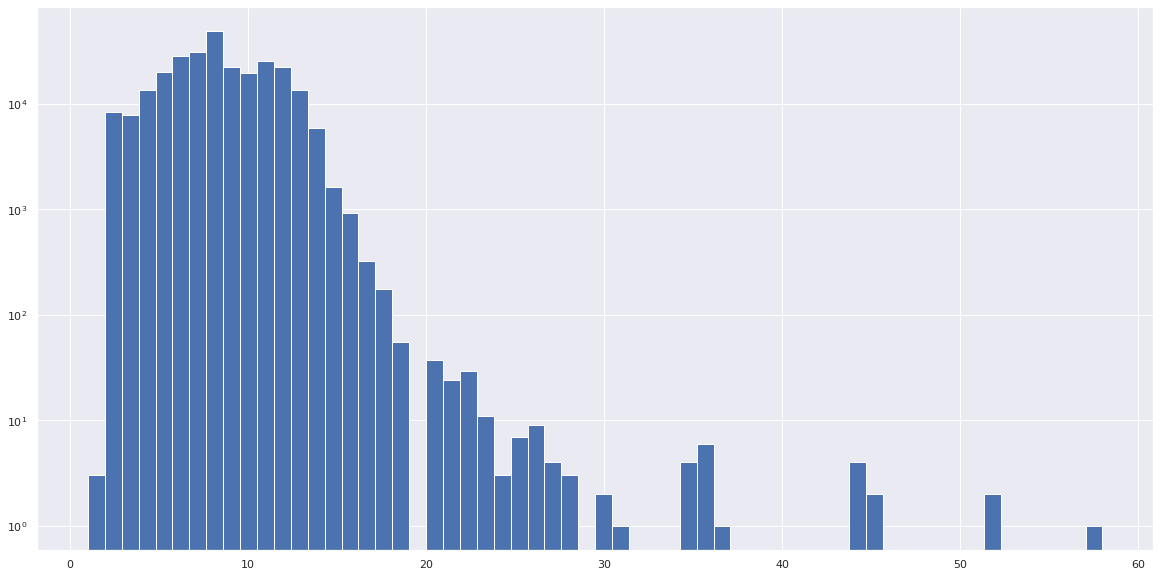

In [54]:
num_images_per_product = dfs.groupby('product_id').agg(len)['image_path']
plt.figure(figsize=(20, 10))
plt.hist(num_images_per_product, bins=60, log=True)
pass

In [57]:
len(set(dfs['category_label']))

107

In [141]:
is_test = dfs.product_id.isin(set(test.product_id))
is_valid = dfs.product_id.isin(set(valid.product_id))

test_plain = dfs[is_test]
valid_plain = dfs[is_valid]
train_plain = dfs[~(is_test | is_valid)]

dfs.to_csv('plain_full.csv', index=False)
test_plain.to_csv('plain_test.csv', index=False)
valid_plain.to_csv('plain_valid.csv', index=False)
train_plain.to_csv('plain_train.csv', index=False)

In [85]:
train_plain

,image_path,product_id,category_label
0,images/product/G/O/GO001CUBHJ95_1.jpg,0,73
1,images/product/G/O/GO001CUBHJ95_2.jpg,0,73
2,images/product/G/O/GO001CUBHJ95_3.jpg,0,73
3,images/product/G/O/GO001CUBHJ95_4.jpg,0,73
4,images/large/new/80000/82733-1.jpg,0,73
...,...,...,...
2232302,images/large/new/13690000/13697674-2.jpg,270634,19
2232303,images/large/new/13690000/13697674-3.jpg,270634,19
2232304,images/large/new/13690000/13697674-4.jpg,270634,19
2232305,images/large/new/13690000/13697674-5.jpg,270634,19


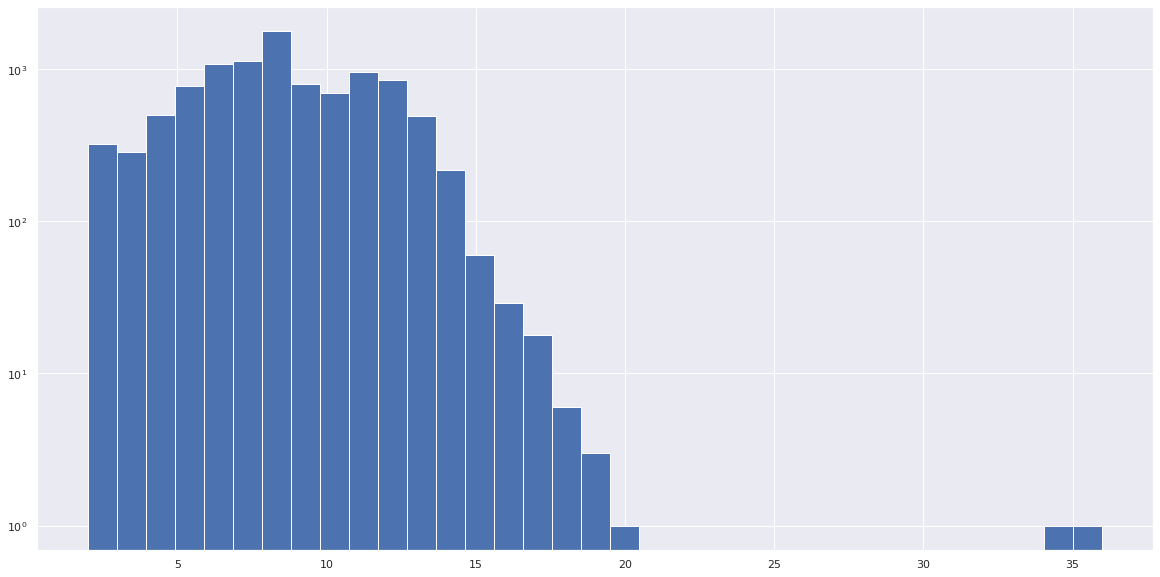

In [155]:
num_images_per_product = valid_plain.groupby('product_id').agg(len)['image_path']
plt.figure(figsize=(20, 10))
plt.hist(num_images_per_product, bins=35, log=True)
pass

In [60]:
valid_plain

,image_path,product_id,category_label
1056,images/product/C/A/CA994EMBQV07_1630315_1_v2.jpg,107,66
1057,images/product/C/A/CA994EMBQV07_1630316_2_v2.jpg,107,66
1058,images/product/C/A/CA994EMBQV07_1630317_3_v2.jpg,107,66
1059,images/large/new/230000/235746-1.jpg,107,66
1060,images/large/new/230000/235746-2.jpg,107,66
...,...,...,...
2231054,images/large/new/11800000/11805323-2.jpg,270502,104
2231055,images/large/new/11800000/11805323-3.jpg,270502,104
2231056,images/large/new/11800000/11805323-4.jpg,270502,104
2231057,images/large/new/11800000/11805323-5.jpg,270502,104


In [134]:
path_id =
test_plain[['image_path']].reset_index().rename(columns={'index': 'id', 'image_path': 'path'}).set_index('path')['id']
path_id_dict = path_id.to_dict()
path_id.to_csv('benchmark/test_img_paths.csv')

relevance = test.apply(lambda x: x['wb_img_paths'] + x['lm_img_paths'], axis=1)
relevance_id = relevance.apply(lambda x: [path_id_dict[i] for i in x])

all_nser = pd.concat([relevance_id.apply(lambda x: x[0]), relevance_id.apply(lambda x: x[1:])], axis=1)
all_nser = all_nser.rename(columns={0: 'query', 1: 'relevant'})
all_nser['scores'] = all_nser['relevant'].apply(lambda x: ' '.join(['1'] * len(x)))
all_nser['relevant'] = all_nser['relevant'].apply(lambda x: ' '.join(map(str, x)))
all_nser.to_csv('benchmark/test_query_relevant.csv', index=False)

In [135]:
path_id =
valid_plain[['image_path']].reset_index().rename(columns={'index': 'id', 'image_path': 'path'}).set_index('path')['id']
path_id_dict = path_id.to_dict()
path_id.to_csv('benchmark/valid_img_paths.csv')

relevance = valid.apply(lambda x: x['wb_img_paths'] + x['lm_img_paths'], axis=1)
relevance_id = relevance.apply(lambda x: [path_id_dict[i] for i in x])

all_nser = pd.concat([relevance_id.apply(lambda x: x[0]), relevance_id.apply(lambda x: x[1:])], axis=1)
all_nser = all_nser.rename(columns={0: 'query', 1: 'relevant'})
all_nser['scores'] = all_nser['relevant'].apply(lambda x: ' '.join(['1'] * len(x)))
all_nser['relevant'] = all_nser['relevant'].apply(lambda x: ' '.join(map(str, x)))
all_nser.to_csv('benchmark/valid_query_relevant.csv', index=False)